In [261]:
import numpy as np
from spectral_clustering import spectral_clustering
import functions_for_plotting
from asymmetric_laplacian_distribution import get_index_per_class, get_labels, labels_to_layout_mapping
from sklearn.cluster import KMeans
import training_set_split
import seaborn as sns
import prediction_strength
import importlib
import matplotlib.pyplot as plt
from prediction_strength import get_F1_score_per_k
from matplotlib.legend import Legend
import scipy

# Eigenvalue Gap Heuristic

## Finding the number of clusters k

A common heuristic to choose the "right" number of clusters is to make use of the so called "eigenvalue gap" (also called spectral gap) (Tibshirani, Walther & Hastie 2001;Bolla
1991; Mohar 1997 ; Chung 1997). It describes the absolute difference between to succesive eigenvalues with the goal to choose the number of clusters k such that all eigenvalues λ1 , . . . , λk are very small, but λk+1 is relatively large. 
This relatively large gap can and is definied in several ways in the literature. 
While some use the maximum abosolute difference, others use approaches inspired by outlier detection. 
Referring to Luxburg (2007), "the eigengap heuristic usually works well if the data contains very well pronounced clusters, but in ambiguous cases it also returns ambiguous results."
It must also be mentioned that the eigenvalue gap is affected by the choice of the connectivity parameters
of the neighborhood graph which is itself not a trivial problem. 

In our analysis we defined the eigenvalue gap as the the first $k$ for which $|\lambda_{k+1} - \lambda_{k}| > mean(\lambda_{1\cdots100}) + std(\lambda_{1\cdots100})$. In addition in cases where we saw a strong appealing eigenvalue gap we also took this visual detectable eigenvalue gap into account.   
We decied to base our heuristic on the first 100 eigenvale because we artificially increased the dimensions of the dataset by zero-padding. This reduces the informative value of the eigenvalues. We hope that the main information is captures by the first 100 Eigenvalues. Furthermore, we assume the that less than 100 cluster present in the dataset.


# Load Eigenvalues

In [262]:
data_dir =""#'WagenaarData/Day20/Eigenvalues/'
eigval_total = np.load(data_dir + "eigval_culture_2_2_Euclidean_k=10_reg=None_100clusters.npy")

In [263]:
eigval = eigval_total
eig_differences = np.diff(eigval)

# Heuristics

## Mean Difference Heuristic

In [264]:
mean_eig_difference = np.mean(eig_differences)
k_mean = (np.where(eig_differences>mean_eig_difference)[0]+1)[0]
if k_mean == 1:
    print("No trivial solution!!!")
    k_mean = (np.where(eig_differences>mean_eig_difference)[0]+1)[1]
print("Mean Differnce Heuristic: k =", k_mean)

Mean Differnce Heuristic: k = 3


## Mean Difference + Std Heuristic

In [265]:
threshold = mean_eig_difference+1*np.std(eig_differences)
k_std = (np.where(eig_differences >threshold)[0] + 1)[0]
if k_std == 1:
    print("No trivial solution!!!")
    k_std = (np.where(eig_differences>threshold)[0]+1)[1]

print("Mean Differnce + Std Heuristic: k =", k_std)

Mean Differnce + Std Heuristic: k = 4


## Max Difference

In [266]:
k_max = np.argmax(eig_differences) + 1
if k_max == 1:
    print("No trivial solution!!!")
    k_max = np.argmax(eig_differences[1])+1+1

print("Max Differnce Heuristic: k =", k_max)

Max Differnce Heuristic: k = 31821


## Mean Difference of first 100 Eigenvalues Heuristic

In [267]:
k_mean_100 = (np.where(eig_differences > np.mean(eig_differences[0:100]))[0] +1)[0]
if k_mean_100 == 1:
    print("No trivial solution!!!")
    k_mean_100 = (np.where(eig_differences>np.mean(eig_differences[0:100]))[0]+1)[1]
    
print("Mean Differnce of first 100 Eigenvalues Heuristic: k =", k_mean_100)

Mean Differnce of first 100 Eigenvalues Heuristic: k = 4


## Mean Difference + Std of first 100 Eigenvalues Heuristic

In [268]:
k_std_100 = (np.where(eig_differences > (np.mean(eig_differences[0:100])+1*np.std(eig_differences[0:100])))[0] + 1)[0]
if k_std_100 == 1:
    print("No trivial solution!!!")
    k_std_100 = (np.where(eig_differences > (np.mean(eig_differences[0:100])+1*np.std(eig_differences[0:100])))[0]+1)[1]


print("Mean Differnce + Std of first 100 Eigenvalues Heuristic: k =", k_std_100)

Mean Differnce + Std of first 100 Eigenvalues Heuristic: k = 4


# Plot Eigenvalues

In [269]:
title = "Eigenvalues of Graph Laplacian for Culture 2.2 \n reg = None"
save_file = "eigenvalues_culture_2_2_Euclidean_k=10_reg=None_weighting=False_100clusters_first_100.pdf"

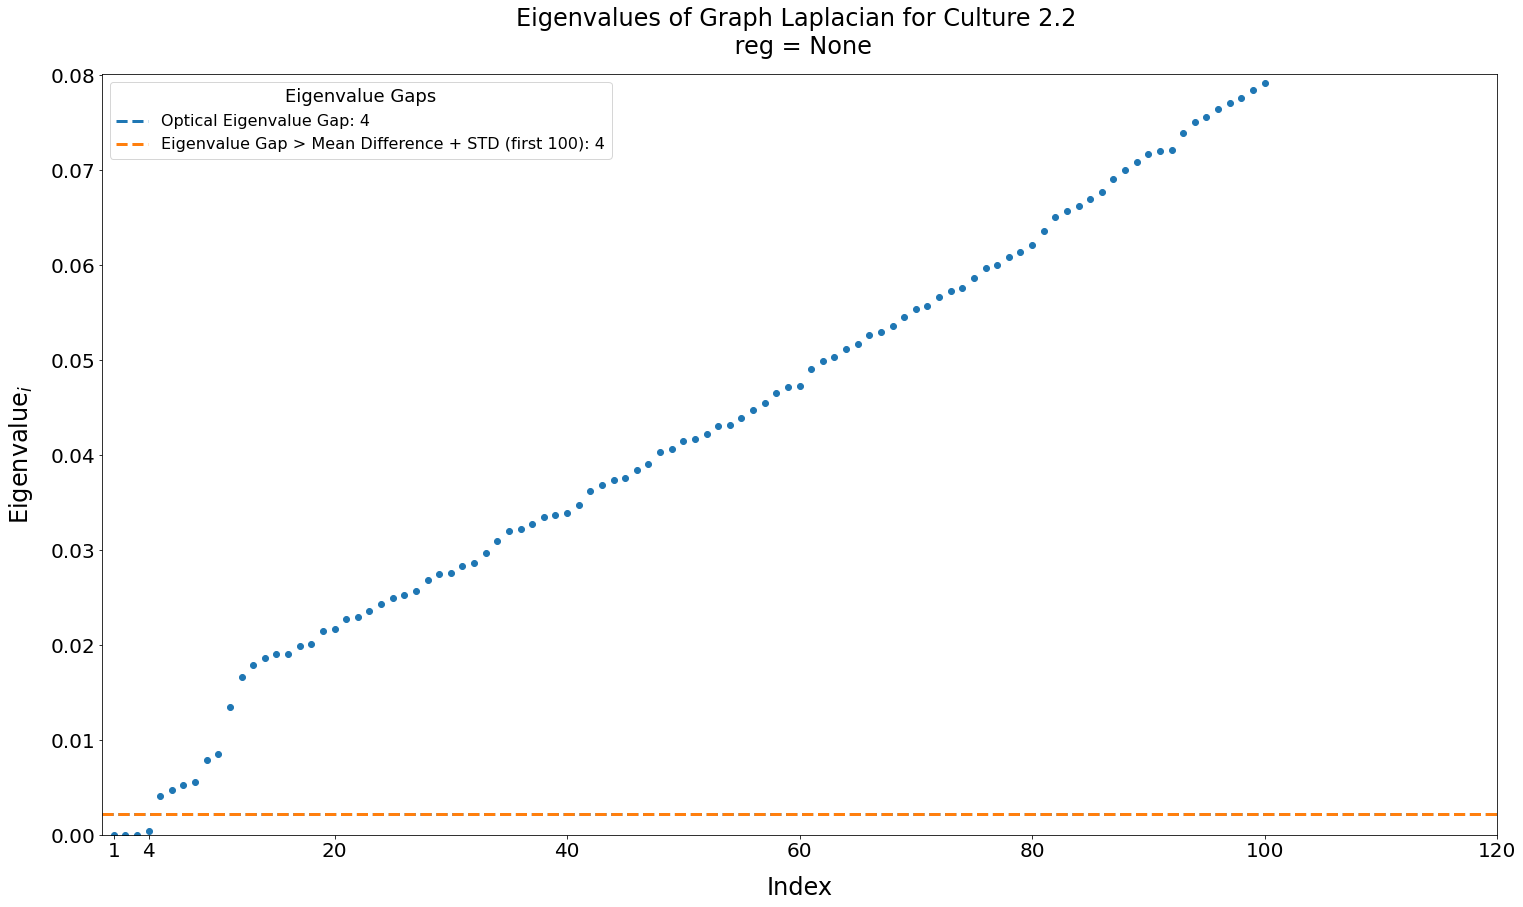

In [272]:
fig, ax = plt.subplots(figsize=(25,14))
eigenvalue_range = [0,100]
optical_k_clusters = 4
true_n_clusters = None

if eigenvalue_range:
    ax.scatter(range(eigenvalue_range[0]+1,eigenvalue_range[1]+1), eigval[eigenvalue_range[0]:eigenvalue_range[1]])
    ax.set_xlim(eigenvalue_range[0],eigenvalue_range[1]+1)
    ax.set_ylim(eigval[eigenvalue_range[0]], eigval[eigenvalue_range[1]+1])
    if true_n_clusters:
        x_gaps = np.unique([true_n_clusters,optical_k_clusters,k_std_100])
        x_gaps = x_gaps[x_gaps<eigenvalue_range[1]+1]
    else:
        x_gaps = np.unique([optical_k_clusters,k_std_100])
        x_gaps = x_gaps[x_gaps<eigenvalue_range[1]+1]
    
else:
    ax.scatter(range(len(eigval)), eigval)
    if true_n_clusters:
        x_gaps = np.unique([true_n_clusters,optical_k_clusters,k_std_100])
        x_gaps = x_gaps[x_gaps<eigenvalue_range[1]+1]
    else:
        x_gaps = np.unique([optical_k_clusters,k_std_100])
        x_gaps = x_gaps[x_gaps<eigenvalue_range[1]+1]
    
    
if true_n_clusters:    
    ax.axhline(eigval[true_n_clusters - 1] + (eigval[true_n_clusters] - eigval[true_n_clusters - 1]) / 2, c="C0", linestyle="-",
                label="True N Clusters Eigenvalue Gap: " + str(true_n_clusters),  linewidth=3)
    ax.axhline(eigval[optical_k_clusters - 1] + (eigval[optical_k_clusters] - eigval[optical_k_clusters - 1]) / 2, c="C0", linestyle="--",
                    label="Optical Eigenvalue Gap: " + str(optical_k_clusters),  linewidth=3)

else:
    ax.axhline(eigval[optical_k_clusters - 1] + (eigval[optical_k_clusters] - eigval[optical_k_clusters - 1]) / 2, c="C0", linestyle="--",
                    label="Optical Eigenvalue Gap: " + str(optical_k_clusters),  linewidth=3)


ax.axhline(eigval[k_std_100 - 1] + (eigval[k_std_100] - eigval[k_std_100 - 1]) / 2, c="C1", linestyle="--",
                label="Eigenvalue Gap > Mean Difference + STD (first 100): " + str(k_std_100),linewidth=3)


x_ticks = plt.xticks([1] + list(plt.xticks()[0][1:]) + list(x_gaps))

ax.set_xlabel("Index", fontsize=24, labelpad=15)
ax.set_ylabel("Eigenvalue$_i$", fontsize=24,labelpad=15)
ax.set_title(title, fontsize=24, pad=20)
leg = ax.legend(fontsize=16, loc ="upper left", title = "Eigenvalue Gaps")
plt.setp(leg.get_title(),fontsize='18')
ax.tick_params(axis='both', labelsize=20)
#plt.savefig(save_file)
#plt.close()

# Plot Eigenvalues (different heuristics in comparison) 

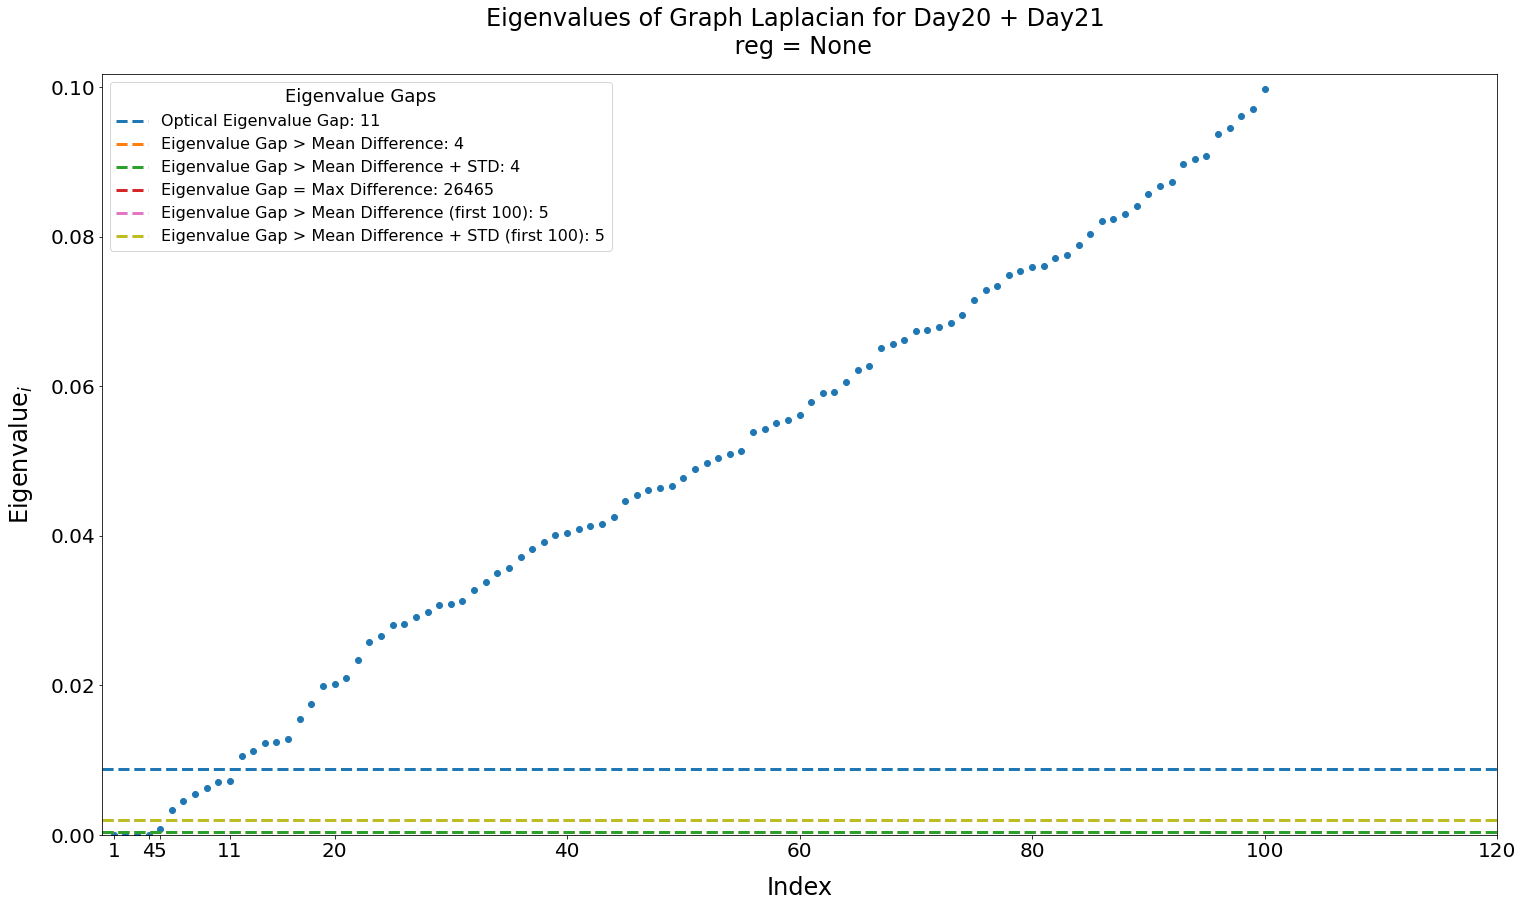

In [36]:
fig, ax = plt.subplots(figsize=(25,14))
eigenvalue_range = [0,100]
k_clusters = 11
n_clusters = None

if eigenvalue_range:
    ax.scatter(range(eigenvalue_range[0]+1,eigenvalue_range[1]+1), eigval[eigenvalue_range[0]:eigenvalue_range[1]])
    ax.set_xlim(eigenvalue_range[0],eigenvalue_range[1]+1)
    ax.set_ylim(eigval[eigenvalue_range[0]], eigval[eigenvalue_range[1]+1])
    if n_clusters:
        x_gaps = np.unique([n_clusters,k_clusters,k_mean,k_std,k_max,k_mean_100,k_std_100])
        x_gaps = x_gaps[x_gaps<eigenvalue_range[1]+1]
    else:
        x_gaps = np.unique([k_clusters,k_mean,k_std,k_max,k_mean_100,k_std_100])
        x_gaps = x_gaps[x_gaps<eigenvalue_range[1]+1]
    
else:
    ax.scatter(range(len(eigval)), eigval)
    x_gaps = np.unique([k_clusters,k_mean,k_std,k_max,k_mean_100,k_std_100])
    
    
if n_clusters:    
    ax.axhline(eigval[n_clusters - 1] + (eigval[n_clusters] - eigval[n_clusters - 1]) / 2, c="C0", linestyle="-",
                label="True N Clusters Eigenvalue Gap: " + str(n_clusters),  linewidth=3)
    ax.axhline(eigval[k_clusters - 1] + (eigval[k_clusters] - eigval[k_clusters - 1]) / 2, c="C0", linestyle="--",
                    label="True Clear Clusters Eigenvalue Gap: " + str(k_clusters),  linewidth=3)

else:
    ax.axhline(eigval[k_clusters - 1] + (eigval[k_clusters] - eigval[k_clusters - 1]) / 2, c="C0", linestyle="--",
                    label="Optical Eigenvalue Gap: " + str(k_clusters),  linewidth=3)


ax.axhline(eigval[k_mean - 1] + (eigval[k_mean] - eigval[k_mean - 1]) / 2, c="C1", linestyle="--",
                label="Eigenvalue Gap > Mean Difference: " + str(k_mean),linewidth=3)
  
ax.axhline(eigval[k_std - 1] + (eigval[k_std] - eigval[k_std - 1]) / 2, c="C2", linestyle="--",
                label="Eigenvalue Gap > Mean Difference + STD: " + str(k_std),linewidth=3)

ax.axhline(eigval[k_max - 1] + (eigval[k_max] - eigval[k_max - 1]) / 2, c="C3", linestyle="--",
                label="Eigenvalue Gap = Max Difference: " + str(k_max),linewidth=3)

ax.axhline(eigval[k_mean_100 - 1] + (eigval[k_mean_100] - eigval[k_mean_100 - 1]) / 2, c="C6", linestyle="--",
                label="Eigenvalue Gap > Mean Difference (first 100): " + str(k_mean_100),linewidth=3)

ax.axhline(eigval[k_std_100 - 1] + (eigval[k_std_100] - eigval[k_std_100 - 1]) / 2, c="C8", linestyle="--",
                label="Eigenvalue Gap > Mean Difference + STD (first 100): " + str(k_std_100),linewidth=3)



x_ticks = plt.xticks([1] + list(plt.xticks()[0][1:]) + list(x_gaps))

ax.set_xlabel("Index", fontsize=24, labelpad=15)
ax.set_ylabel("Eigenvalue$_i$", fontsize=24,labelpad=15)
ax.set_title(title, fontsize=24, pad=20)
leg = ax.legend(fontsize=16, loc ="upper left", title = "Eigenvalue Gaps")
plt.setp(leg.get_title(),fontsize='18')
ax.tick_params(axis='both', labelsize=20)
#plt.savefig(save_file)
#plt.close()